In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns

In [3]:
class StandardScaler:
    """
    Standardize features by removing the mean and scaling to unit variance.
    
    The standard score of a sample x is calculated as:
        z = (x - u) / s
    where u is the mean of the training samples, and s is the standard deviation.
    """
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        self.var_ = None
    
    def fit(self, X):
        """
        Compute the mean and standard deviation of X for later scaling.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The data used to compute the mean and standard deviation.
        """
        X = np.array(X)
        self.mean_ = np.mean(X, axis=0)
        self.var_ = np.var(X, axis=0)
        self.scale_ = np.sqrt(self.var_)
        self.scale_[self.scale_ == 0.0] = 1.0
        return self
    
    def transform(self, X):
        """
        Perform standardization by centering and scaling.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            The data to standardize.
        """
        X = np.array(X)
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        """
        Fit to data, then transform it.
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X):
        """
        Scale back the data to the original representation.
        """
        X = np.array(X)
        return X * self.scale_ + self.mean_

In [5]:
class TSNE:
    """
    t-distributed Stochastic Neighbor Embedding implementation.
    
    Parameters:
    -----------
    n_components : int, default=2
        Dimension of the embedded space.
    perplexity : float, default=30.0
        Related to the number of nearest neighbors. Larger datasets usually require
        larger perplexity.
    learning_rate : float, default=200.0
        The learning rate for t-SNE.
    n_iter : int, default=1000
        Maximum number of iterations for optimization.
    """
    def __init__(self, n_components=2, perplexity=30.0, learning_rate=200.0, n_iter=1000, random_state=None):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.random_state = random_state
    
    def _compute_pairwise_distances(self, X):
        """Compute pairwise distances between points in X."""
        sum_X = np.sum(np.square(X), axis=1)
        D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        return np.maximum(D, 0)  
    
    def _compute_joint_probabilities(self, distances, perplexity):
        """Convert distances to joint probabilities P_ij."""
        n_samples = distances.shape[0]
        P = np.zeros((n_samples, n_samples))
        
        target = np.log(perplexity)
        for i in range(n_samples):
            D = distances[i]
            left = -1000
            right = 1000
            tolerance = 1e-5
            
            D = np.concatenate([D[:i], D[i+1:]])
            
            for _ in range(50):  
                sigma = (left + right) / 2
                sum_P = 0
                
                P_cond = np.exp(-D / (2 * sigma**2))
                sum_P = np.sum(P_cond)
                
                if sum_P == 0:
                    H = 0
                else:
                    P_cond = P_cond / sum_P
                    H = -np.sum(P_cond * np.log2(P_cond + 1e-7))
                
                if H > target:
                    right = sigma
                else:
                    left = sigma
                
                if np.abs(H - target) < tolerance:
                    break
            
            P_cond = np.exp(-D / (2 * sigma**2))
            P_cond = P_cond / np.sum(P_cond)
            
            P[i] = np.concatenate([P_cond[:i], [0], P_cond[i:]])
        
        P = (P + P.T) / (2 * n_samples)
        P = np.maximum(P, 1e-12)
        
        return P
    
    def _compute_gradient(self, P, Y):
        """Compute gradient of KL divergence between P and Q."""
        n_samples = P.shape[0]
        
        sum_Y = np.sum(np.square(Y), axis=1)
        num = 1 / (1 + np.add(np.add(-2 * np.dot(Y, Y.T), sum_Y).T, sum_Y))
        np.fill_diagonal(num, 0)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        
        PQ_diff = P - Q
        gradient = np.zeros((n_samples, self.n_components))
        for i in range(n_samples):
            gradient[i] = 4 * np.sum(np.multiply(
                PQ_diff[i:i+1].T + PQ_diff[:,i:i+1],
                num[i:i+1].T + num[:,i:i+1]
            ).reshape(-1, 1) * (Y[i:i+1] - Y), axis=0)
        
        return gradient
    
    def fit_transform(self, X):
        """
        Fit X into an embedded space and return that transformed output.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
            Samples to be transformed.
            
        Returns:
        --------
        Y : array-like of shape (n_samples, n_components)
            Embedding of the training data in low-dimensional space.
        """
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        n_samples = X.shape[0]
        
        Y = np.random.randn(n_samples, self.n_components) * 0.0001
        
        distances = self._compute_pairwise_distances(X)
        P = self._compute_joint_probabilities(distances, self.perplexity)
        
        Y_prev = Y.copy()
        Y_update = np.zeros_like(Y)
        
        for iteration in range(self.n_iter):
            gradient = self._compute_gradient(P, Y)
            
            momentum = 0.5 if iteration < 20 else 0.8
            Y_update = momentum * Y_update - self.learning_rate * gradient
            Y = Y + Y_update
            
            Y = Y - np.mean(Y, axis=0)
            
            if iteration > 0 and np.all(np.abs(Y - Y_prev) < 1e-7):
                break
                
            Y_prev = Y.copy()
            
            if (iteration + 1) % 100 == 0:
                print(f"t-SNE iteration {iteration + 1}/{self.n_iter}")
        
        return Y

In [7]:
class Layer:
    def __init__(self, input_dim, output_dim, activation='relu', use_dropout=False, dropout_rate=0.2):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation_name = activation
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        
        scale = np.sqrt(2. / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * scale
        self.b = np.zeros(output_dim)
        self.mask = None
        
    def activation(self, x):
        if self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif self.activation_name == 'tanh':
            return np.tanh(x)
        elif self.activation_name == 'leaky_relu':
            return np.where(x > 0, x, 0.01 * x)
    
    def activation_derivative(self, x):
        if self.activation_name == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation_name == 'sigmoid':
            s = self.activation(x)
            return s * (1 - s)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(x)**2
        elif self.activation_name == 'leaky_relu':
            return np.where(x > 0, 1, 0.01)
    
    def forward(self, input_data, training=True):
        self.input = input_data
        self.z = np.dot(input_data, self.W) + self.b
        self.output = self.activation(self.z)
        
        if self.use_dropout and training:
            self.mask = np.random.binomial(1, 1-self.dropout_rate, size=self.output.shape)
            self.output *= self.mask / (1-self.dropout_rate)
        
        return self.output
    
    def backward(self, grad_output, learning_rate=0.01):
        if self.use_dropout:
            grad_output *= self.mask / (1-self.dropout_rate)
            
        grad_activation = grad_output * self.activation_derivative(self.z)
        grad_W = np.dot(self.input.T, grad_activation)
        grad_b = np.mean(grad_activation, axis=0)
        grad_input = np.dot(grad_activation, self.W.T)
        
        self.W -= learning_rate * grad_W
        self.b -= learning_rate * grad_b
        
        return grad_input

In [9]:
class Autoencoder:
    def __init__(self, input_dim, encoding_dim, hidden_dims=None, 
                 activation='relu', output_activation='sigmoid',
                 use_dropout=False, dropout_rate=0.2):
        if hidden_dims is None:
            hidden_dims = [input_dim // 2]
            
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        
        self.encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                Layer(prev_dim, hidden_dim, activation, use_dropout, dropout_rate)
            )
            prev_dim = hidden_dim
        self.encoder_layers.append(
            Layer(prev_dim, encoding_dim, activation)
        )
        
        self.decoder_layers = []
        prev_dim = encoding_dim
        for hidden_dim in reversed(hidden_dims):
            self.decoder_layers.append(
                Layer(prev_dim, hidden_dim, activation, use_dropout, dropout_rate)
            )
            prev_dim = hidden_dim
        self.decoder_layers.append(
            Layer(prev_dim, input_dim, output_activation)
        )
        
        self.training_history = {
            'loss': [], 'val_loss': [],
            'reconstruction_error': [],
            'gradient_norms': [],
            'layer_activations': []
        }
    
    def encode(self, X, training=True):
        current_input = X
        layer_outputs = []
        for layer in self.encoder_layers:
            current_input = layer.forward(current_input, training)
            layer_outputs.append(np.mean(current_input))
        return current_input, layer_outputs
    
    def decode(self, encoded, training=True):
        current_input = encoded
        layer_outputs = []
        for layer in self.decoder_layers:
            current_input = layer.forward(current_input, training)
            layer_outputs.append(np.mean(current_input))
        return current_input, layer_outputs
    
    def forward(self, X, training=True):
        encoded, encoder_outputs = self.encode(X, training)
        decoded, decoder_outputs = self.decode(encoded, training)
        return decoded, encoded, encoder_outputs + decoder_outputs
    
    def compute_loss(self, X, decoded, loss_type='mse'):
        if loss_type == 'mse':
            return np.mean((X - decoded) ** 2)
        elif loss_type == 'binary_crossentropy':
            epsilon = 1e-15
            decoded = np.clip(decoded, epsilon, 1 - epsilon)
            return -np.mean(X * np.log(decoded) + (1 - X) * np.log(1 - decoded))
    
    def train(self, X, validation_data=None, epochs=100, batch_size=32, 
             learning_rate=0.01, loss_type='mse'):
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            epoch_losses = []
            for i in range(0, n_samples, batch_size):
                batch = X_shuffled[i:i + batch_size]
                
                decoded, encoded, layer_outputs = self.forward(batch, training=True)
                loss = self.compute_loss(batch, decoded, loss_type)
                epoch_losses.append(loss)
                
                grad = decoded - batch if loss_type == 'mse' else \
                       -(batch / decoded - (1 - batch) / (1 - decoded))
                
                for layer in reversed(self.decoder_layers):
                    grad = layer.backward(grad, learning_rate)
                
                for layer in reversed(self.encoder_layers):
                    grad = layer.backward(grad, learning_rate)
                
                self.training_history['layer_activations'].append(layer_outputs)
            
            avg_loss = np.mean(epoch_losses)
            self.training_history['loss'].append(avg_loss)
            
            if validation_data is not None:
                val_decoded, _, _ = self.forward(validation_data, training=False)
                val_loss = self.compute_loss(validation_data, val_decoded, loss_type)
                self.training_history['val_loss'].append(val_loss)
            
            if epoch % 10 == 0:
                val_str = f", Val Loss: {val_loss:.6f}" if validation_data is not None else ""
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}{val_str}")
    
    def plot_training_history(self):
        """Comprehensive visualization of training progress and results"""
        fig = plt.figure(figsize=(20, 15))
        
        ax1 = plt.subplot(3, 3, 1)
        ax1.plot(self.training_history['loss'], label='Training')
        if self.training_history['val_loss']:
            ax1.plot(self.training_history['val_loss'], label='Validation')
        ax1.set_title('Loss History')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2 = plt.subplot(3, 3, 2)
        activations = np.array(self.training_history['layer_activations'])
        for i in range(activations.shape[1]):
            ax2.plot(activations[:, i], label=f'Layer {i+1}')
        ax2.set_title('Layer Activations (Mean)')
        ax2.set_xlabel('Batch')
        ax2.set_ylabel('Mean Activation')
        ax2.legend()
        
        if self.encoding_dim == 2:
            ax3 = plt.subplot(3, 3, 3)
            encoded_data, _ = self.encode(self.example_input, training=False)
            ax3.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.5)
            ax3.set_title('Latent Space Distribution')
            ax3.set_xlabel('Latent Dim 1')
            ax3.set_ylabel('Latent Dim 2')
        
        if hasattr(self, 'example_input'):
            n_samples = min(5, len(self.example_input))
            for i in range(n_samples):
                ax = plt.subplot(3, 3, 4 + i)
                original = self.example_input[i]
                reconstructed, _, _ = self.forward(original.reshape(1, -1), training=False)
                reconstructed = reconstructed.reshape(-1)
                
                if self.input_dim == 2:  
                    ax.scatter([original[0]], [original[1]], c='b', label='Original')
                    ax.scatter([reconstructed[0]], [reconstructed[1]], c='r', label='Reconstructed')
                else:  
                    ax.plot(original, label='Original')
                    ax.plot(reconstructed, label='Reconstructed')
                ax.set_title(f'Sample {i+1} Reconstruction')
                ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def visualize_latent_space(self, X, labels=None):
        """Visualize the latent space using t-SNE if encoding_dim > 2"""
        encoded_data, _ = self.encode(X, training=False)
        
        if self.encoding_dim > 2:
            tsne = TSNE(n_components=2, random_state=42)
            encoded_2d = tsne.fit_transform(encoded_data)
        else:
            encoded_2d = encoded_data
        
        plt.figure(figsize=(10, 8))
        if labels is not None:
            scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, cmap='tab10')
            plt.colorbar(scatter)
        else:
            plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1])
        
        plt.title('Latent Space Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

Epoch 0, Loss: 1.218599, Val Loss: 1.153627
Epoch 10, Loss: 0.812150, Val Loss: 0.742396
Epoch 20, Loss: 0.778922, Val Loss: 0.722142
Epoch 30, Loss: 0.762129, Val Loss: 0.709786
Epoch 40, Loss: 0.759373, Val Loss: 0.702718
Epoch 50, Loss: 0.741864, Val Loss: 0.694653
Epoch 60, Loss: 0.746240, Val Loss: 0.692545
Epoch 70, Loss: 0.735382, Val Loss: 0.688865
Epoch 80, Loss: 0.733301, Val Loss: 0.686753
Epoch 90, Loss: 0.733451, Val Loss: 0.687630


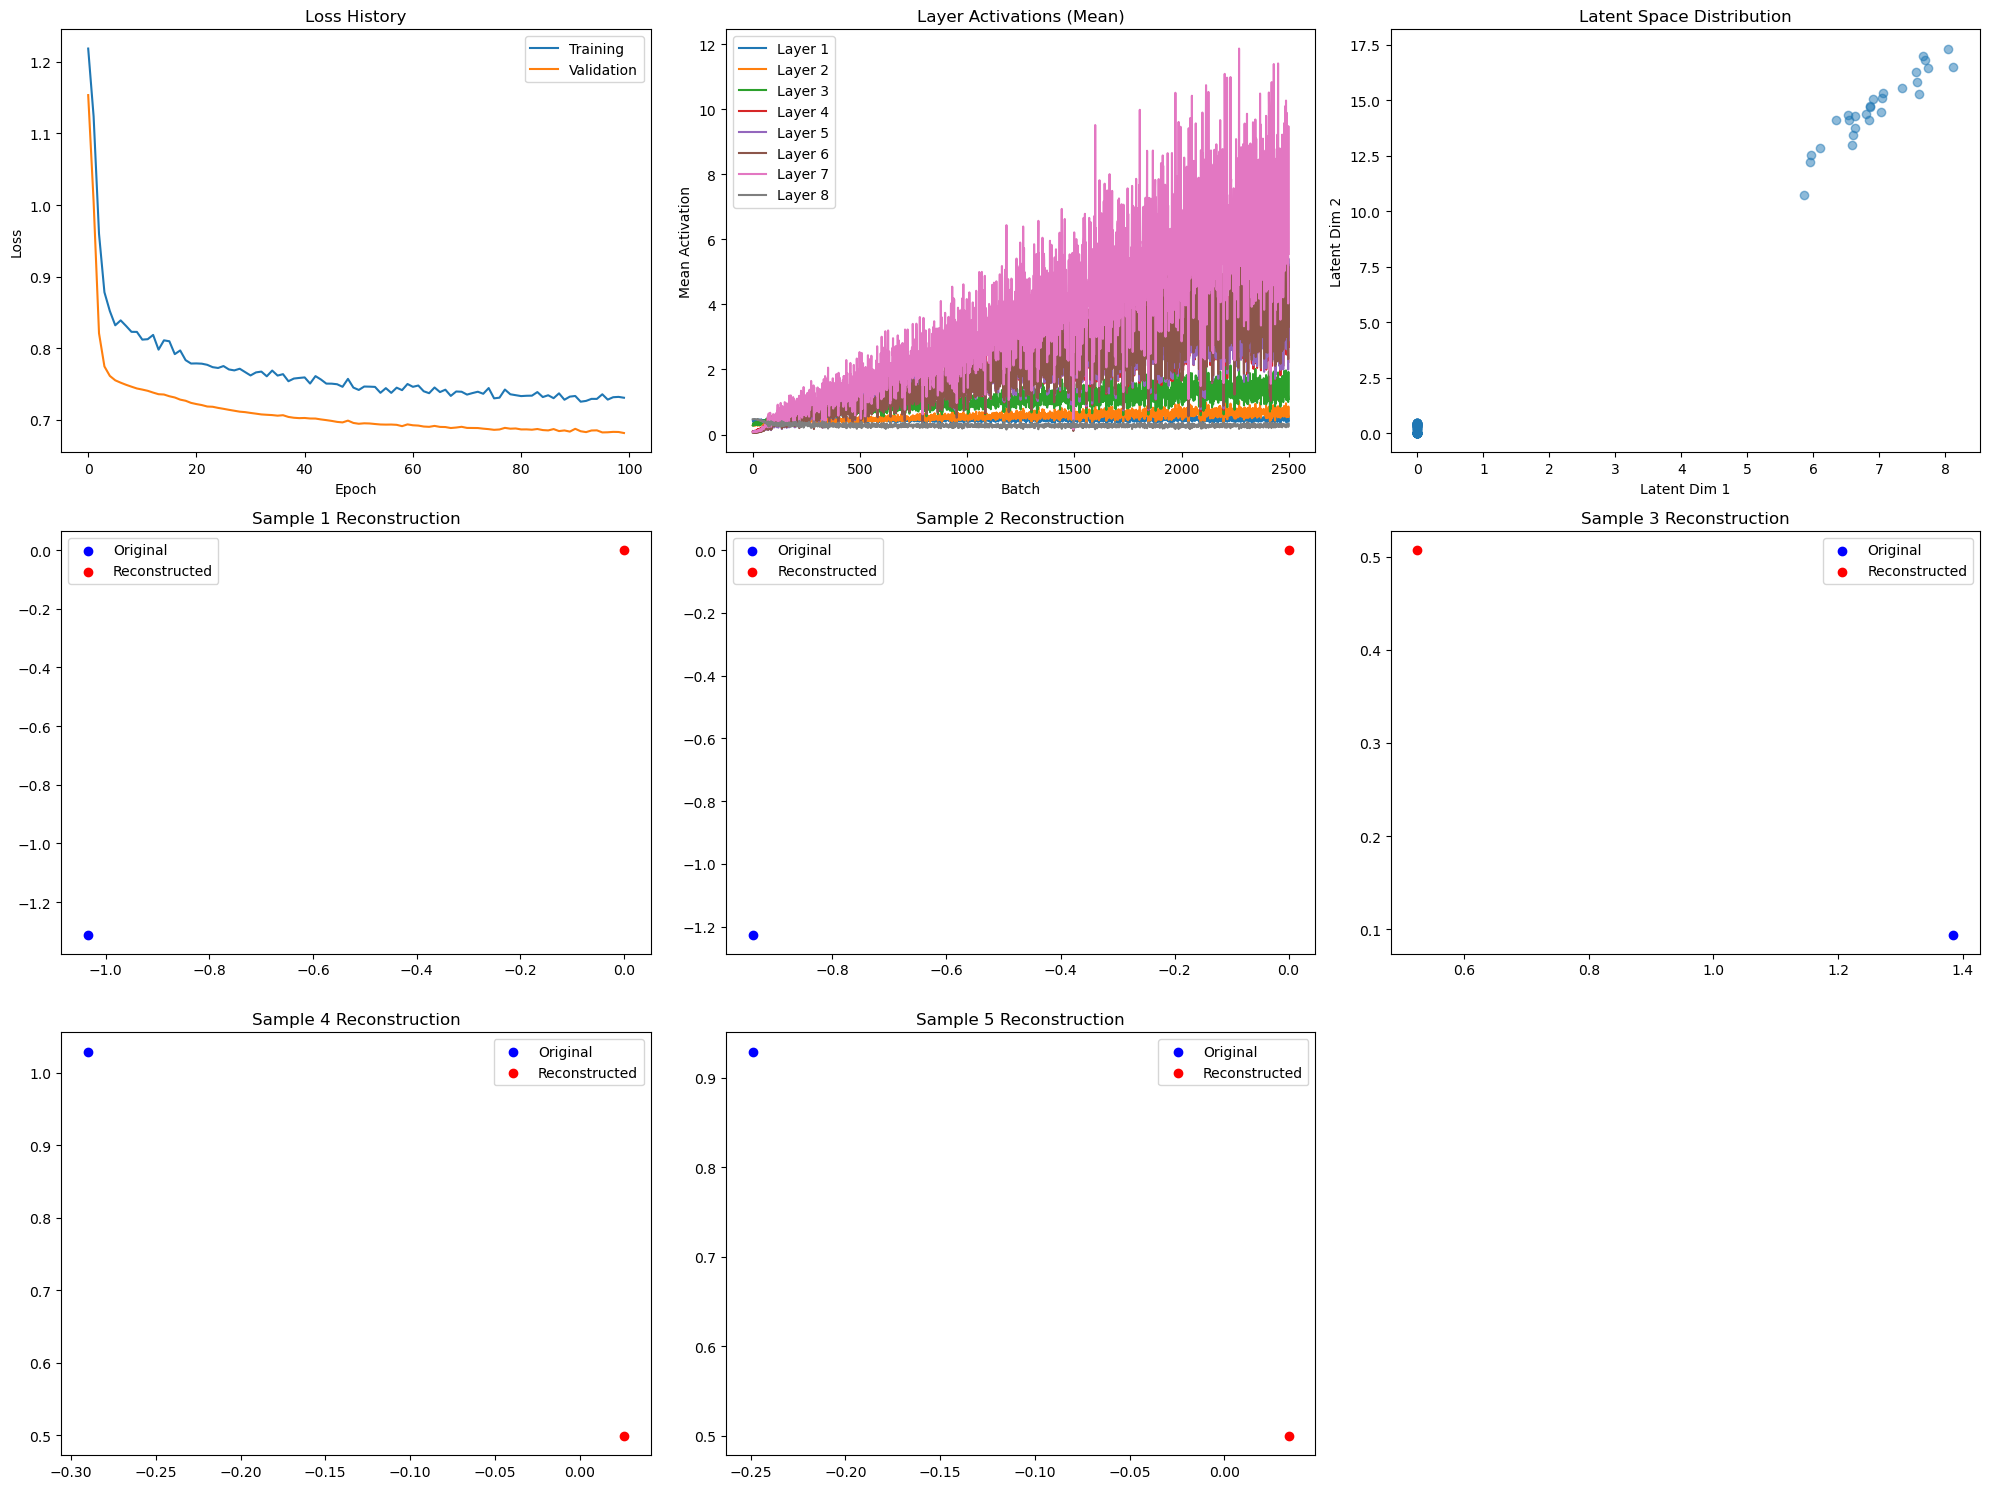

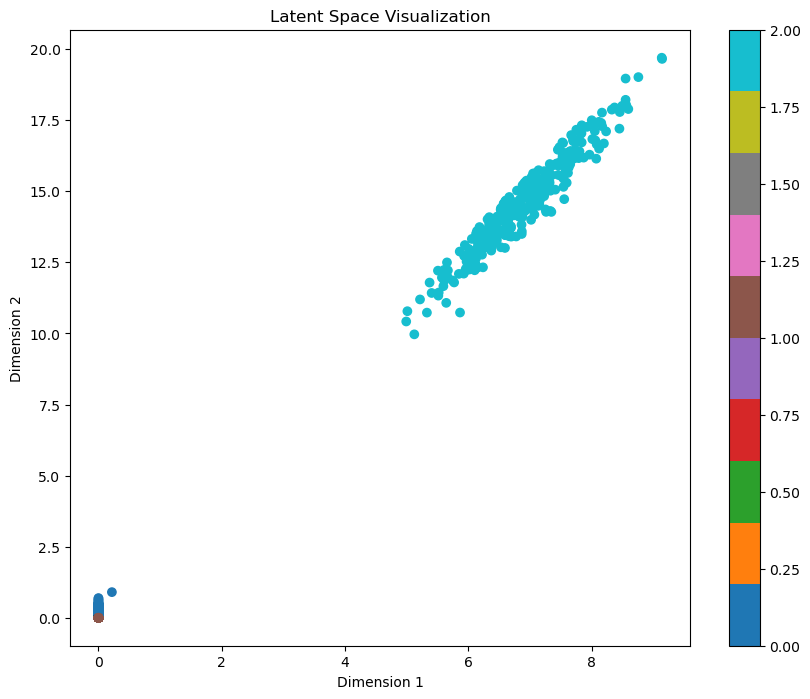

In [11]:
if __name__ == "__main__":
    n_samples = 1000
    n_clusters = 3
    input_dim = 2
    X, labels = make_blobs(n_samples=n_samples, centers=n_clusters, 
                          n_features=input_dim, random_state=42)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    train_size = int(0.8 * n_samples)
    X_train = X[:train_size]
    X_val = X[train_size:]
    
    autoencoder = Autoencoder(
        input_dim=input_dim,
        encoding_dim=2,
        hidden_dims=[8, 6, 4],
        activation='relu',
        output_activation='sigmoid',
        use_dropout=True,
        dropout_rate=0.05
    )
    
    autoencoder.example_input = X_train[:100]
    
    autoencoder.train(X_train, X_val, epochs=100, batch_size=32, 
                     learning_rate=0.001, loss_type='mse')
    
    autoencoder.plot_training_history()
    
    autoencoder.visualize_latent_space(X, labels)